<a href="https://colab.research.google.com/github/amirezzati/Arabic-Broken-Plural-RNN/blob/main/Arabic_broken_plurals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries & Constants**

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Softmax, BatchNormalization, Dropout, Conv2D, MaxPool2D, Embedding, Reshape, Flatten, LSTM, GRU, SimpleRNN, Concatenate, concatenate, RepeatVector, TimeDistributed, Bidirectional
# from keras.layers.merge import concatenate
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD
from tensorflow.keras import Model
from tensorflow.keras.optimizers.schedules import InverseTimeDecay, ExponentialDecay
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences #from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
import os
import string
from google.colab import drive

In [2]:
drive.mount('/content/drive')
dataPath="/content/drive/MyDrive/AI Projects/Arabic Broken Plural/data"

Mounted at /content/drive


# **Preprocessing**

## **Get dataset files and Organizing**

In [3]:
train_csv = pd.read_csv(dataPath+"/train_pairs_all.csv")
dev_csv = pd.read_csv(dataPath+"/dev_pairs_all.csv")
test_csv = pd.read_csv(dataPath+"/test_pairs_all.csv")

train_csv.head()

,lemma,inflection,NUM,GEN,RAT,lex_freq,B/S,SING_PATT,PL_PATT,ROOT,FREQ
0,Eamal,>aEomAl,PL,m,i,49,B,1a2a3,>a1o2A3,E.m.l,49
1,hadaf,>ahodAf,PL,m,i,42,B,1a2a3,>a1o2A3,h.d.f,42
2,EuDow,>aEoDA',PL,m,r,46,B,1u2ow,>a1o2A',E.D.#,39
3,jihAz,>ajohizap,PL,m,i,41,B,1i2A3,>a1o2i3ap,j.h.z,35
4,Hukom,>aHokAm,PL,m,i,35,B,1u2o3,>a1o2A3,H.k.m,35


In [4]:
train_csv_filtered = train_csv[train_csv['ROOT'] != 'NTWS']
dev_csv_filtered = dev_csv[dev_csv['ROOT'] != 'NTWS']
test_csv_filtered = test_csv[test_csv['ROOT'] != 'NTWS']

In [5]:
# Label encoder for encoding gender and rational features
# 'B' class: 0      'S' class: 1
categorical_attr = ['GEN', 'RAT', 'B/S']

le = LabelEncoder()
train_csv_filtered[categorical_attr] = train_csv_filtered[categorical_attr].apply(le.fit_transform, axis=0)

le = LabelEncoder()
dev_csv_filtered[categorical_attr] = dev_csv_filtered[categorical_attr].apply(le.fit_transform, axis=0)

le = LabelEncoder()
test_csv_filtered[categorical_attr] = test_csv_filtered[categorical_attr].apply(le.fit_transform, axis=0)

test_csv_filtered.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,lemma,inflection,NUM,GEN,RAT,lex_freq,B/S,SING_PATT,PL_PATT,ROOT,FREQ
0,Eamal,>aEomAl,PL,1,0,23,0,1a2a3,>a1o2A3,E.m.l,23
1,hadaf,>ahodAf,PL,1,0,16,0,1a2a3,>a1o2A3,h.d.f,16
2,EalAqap,EalAqAt,PL,0,0,15,1,1a2A3ap,1a2A3At,E.l.q,15
3,mu&as~asap,mu&as~asAt,PL,0,0,14,1,mu&a2~a3ap,mu&a2~a3At,#.s.s,14
4,EuDow,>aEoDA',PL,1,1,15,0,1u2ow,>a1o2A',E.D.#,13


In [6]:
def getNumpyData(dataFrame):
  '''
  Output type->List : 0:lamma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational | 8:freq | 9:nmberOfRoot
  '''
  data = [] # 0:lemma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational 
  data.append(dataFrame['lemma'].to_numpy())
  data.append(dataFrame['SING_PATT'].to_numpy())

  root = dataFrame['ROOT'].to_numpy()
  # delete dot sign(.) in root feature
  for i in range(len(root)): 
    root[i] = root[i].replace(".","")
    root[i] = root[i].replace("#","")
  data.append(root)

  data.append(dataFrame['inflection'].to_numpy())
  data.append(dataFrame['PL_PATT'].to_numpy())
  data.append(dataFrame['B/S'].to_numpy())
  data.append(dataFrame['GEN'].to_numpy())
  data.append(dataFrame['RAT'].to_numpy())
  data.append(dataFrame['FREQ'].to_numpy())

  numOfRoot = [len(x) for x in root]
  data.append(np.array(numOfRoot))

  print(data[0].shape)
  return data

trainData = getNumpyData(train_csv_filtered)
devData = getNumpyData(dev_csv_filtered)
testData = getNumpyData(test_csv_filtered)

(2748,)
(1113,)
(1076,)


## **Analyzing Datasets**

In [7]:
# generate samples of dev/test set which are not in train set
# compare with lemma
devSetExistence = np.array([lemma in trainData[0] for lemma in devData[0]])
testSetExistence = np.array([lemma in trainData[0] for lemma in testData[0]])

unseenLemmaIndices_dev = np.where(devSetExistence==False)[0]
unseenLemmaIndices_test = np.where(testSetExistence==False)[0]

print('number of unseen data(lemma) in dev set: ', np.count_nonzero(devSetExistence==False))
print('number of unseen data(lemma) in test set: ', np.count_nonzero(testSetExistence==False), end='\n\n')

# compare with (lemma, inflection) pair
  # first: generate (lemma, inflection) pair in sets
trainLemmaInf = np.stack((trainData[0], trainData[3]), axis=-1).tolist()
devLemmaInf = np.stack((devData[0], devData[3]), axis=-1).tolist()
testLemmaInf = np.stack((testData[0], testData[3]), axis=-1).tolist()

devSetExistence = np.array([lemInf in trainLemmaInf for lemInf in devLemmaInf])
testSetExistence = np.array([lemInf in trainLemmaInf for lemInf in testLemmaInf])

unseenLemInfIndices_dev = np.where(devSetExistence==False)[0]
unseenLemInfIndices_test = np.where(testSetExistence==False)[0]

print('number of unseen data((lemma, inflection) pair) in dev set: ', np.count_nonzero(devSetExistence==False))
print('number of unseen data((lemma, inflection) pair) in test set: ', np.count_nonzero(testSetExistence==False))

number of unseen data(lemma) in dev set:  80
number of unseen data(lemma) in test set:  75

number of unseen data((lemma, inflection) pair) in dev set:  102
number of unseen data((lemma, inflection) pair) in test set:  85


In [8]:
# create dataframe for dev set's unseen data
    # 0:lemma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational 
    
path = '/content/drive/MyDrive/AI Projects/Arabic Broken Plural/Datasets analysis/'
# os.makedirs(path, exist_ok=True)  

unseenLemmaIndices_dev_df = pd.DataFrame({'index': unseenLemmaIndices_dev,
                                           'lemma': devData[0][unseenLemmaIndices_dev],
                                           'inflection': devData[3][unseenLemmaIndices_dev],
                                           'pl pattern': devData[4][unseenLemmaIndices_dev]})
unseenLemmaIndices_dev_df.to_csv(path + 'unseenLemma_dev.csv')


unseenLemInfIndices_dev_df = pd.DataFrame({'index': unseenLemInfIndices_dev,
                                           'lemma': devData[0][unseenLemInfIndices_dev],
                                           'inflection': devData[3][unseenLemInfIndices_dev],
                                           'pl pattern': devData[4][unseenLemInfIndices_dev]})
unseenLemInfIndices_dev_df.to_csv(path + 'unseenLemInf_dev.csv')

In [9]:
unseenLemInfIndices_dev_df.head()

,index,lemma,inflection,pl pattern
0,220,muHaw~il,muHaw~ilAt,mu1aw~i3At
1,230,mujawohar,mujawoharAt,mu1awo3a4At
2,278,Haloy,Huliy~,1u2iy~
3,293,tAriyx,tawAriyx,tawA2iy3
4,383,madad,>amodAd,>a1o2A3


In [10]:
# create dataframe for test set's unseen data
unseenLemmaIndices_test_df = pd.DataFrame({'index': unseenLemmaIndices_test,
                                           'lemma': testData[0][unseenLemmaIndices_test],
                                           'inflection': testData[3][unseenLemmaIndices_test],
                                           'pl pattern': testData[4][unseenLemmaIndices_test]})
unseenLemmaIndices_test_df.to_csv(path + 'unseenLemma_test.csv')


unseenLemInfIndices_test_df = pd.DataFrame({'index': unseenLemInfIndices_test,
                                           'lemma': testData[0][unseenLemInfIndices_test],
                                           'inflection': testData[3][unseenLemInfIndices_test],
                                           'pl pattern': testData[4][unseenLemInfIndices_test]})
unseenLemInfIndices_test_df.to_csv(path + 'unseenLemInf_test.csv')

In [11]:
unseenLemInfIndices_test_df.head()

,index,lemma,inflection,pl pattern
0,177,minaS~ap,minaS~At,mi1a2~At
1,270,muDorib,muDoribiyn,mu1o2i3iyn
2,307,Eubuw~ap,Eubuw~At,1u2uw~At
3,332,rafiyqap,rafiyqAt,1a2iy3At
4,355,sAEidap,sawAEid,1awA2i3


## **Encoding Datasets (Character-based)**

In [12]:
# generate character encoding
oov_token = 'not available char'
char_index = {oov_token: 0}

def updateCharIndex(data):
  global char_index
  # encode input with encoding character set
  for i in range(len(data[0])):
      chars = list(data[0][i]) + list(data[1][i]) + list(data[3][i]) + list(data[4][i])
      for c in chars:
          if c not in char_index:
              char_index[c] = len(char_index)

updateCharIndex(trainData)
print(len(char_index))
print(char_index)

48
{'not available char': 0, 'E': 1, 'a': 2, 'm': 3, 'l': 4, '1': 5, '2': 6, '3': 7, '>': 8, 'o': 9, 'A': 10, 'h': 11, 'd': 12, 'f': 13, 'u': 14, 'D': 15, 'w': 16, "'": 17, 'j': 18, 'i': 19, 'z': 20, 'p': 21, 'H': 22, 'k': 23, 'n': 24, 'S': 25, 'r': 26, '4': 27, 'q': 28, '~': 29, 'y': 30, 't': 31, 's': 32, '<': 33, 'b': 34, 'v': 35, '|': 36, 'T': 37, '}': 38, 'Z': 39, '{': 40, '&': 41, '$': 42, 'x': 43, '*': 44, 'g': 45, 'Y': 46, 'F': 47}


In [13]:
# encode words with character encoder
def encodeWord(word, dic=char_index, oov=oov_token):
    return [dic[c] if c in dic else dic[oov] for c in list(word)]

# encode data and get maximum length of features
def getEncodedData(data):
  '''
  Output type->List : 0:lamma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational | 8:number of root
  '''

  data_encoded = np.copy(data)
  data_encoded[0] = np.array([encodeWord(each) for each in data[0]])
  data_encoded[1] = np.array([encodeWord(each) for each in data[1]])
  data_encoded[2] = np.array([encodeWord(each) for each in data[2]])
  data_encoded[3] = np.array([encodeWord(each) for each in data[3]])
  data_encoded[4] = np.array([encodeWord(each) for each in data[4]])

  lemma_max_len = max([len(each) for each in data_encoded[0]])
  root_max_len = max([len(each) for each in data_encoded[2]])
  inflection_max_len = max([len(each) for each in data_encoded[3]])

  return data_encoded, lemma_max_len, root_max_len, inflection_max_len


trainData_encoded, lemma_max_len, root_max_len, inflection_max_len = getEncodedData(trainData)
devData_encoded, _, _, _  = getEncodedData(devData)
testData_encoded, _, _, _ = getEncodedData(testData)

print('lemma shape train: ', trainData_encoded[0].shape)
print('lemma shape dev: ', devData_encoded[0].shape)
print('lemma shape test: ', testData_encoded[0].shape)
print('max length in lemma elements: ', lemma_max_len)
print('max length in root elements: ', root_max_len)
print('max length in inflection elements: ', inflection_max_len)

lemma shape train:  (2748,)
lemma shape dev:  (1113,)
lemma shape test:  (1076,)
max length in lemma elements:  16
max length in root elements:  4
max length in inflection elements:  17


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=

In [14]:
# ADD padding to sample
# 0:lamma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational 
def getPaddedData(encodedData, lemma_max_len, root_max_len, inflection_max_len):
  data_pad = []
  data_pad.append(np.array(pad_sequences(encodedData[0], maxlen=lemma_max_len, padding='post'))) 
  data_pad.append(np.array(pad_sequences(encodedData[1], maxlen=lemma_max_len, padding='post')))
  data_pad.append(np.array(pad_sequences(encodedData[2], maxlen=root_max_len, padding='post')))
  data_pad.append(np.array(pad_sequences(encodedData[3], maxlen=inflection_max_len, padding='post')))
  data_pad.append(np.array(pad_sequences(encodedData[4], maxlen=inflection_max_len, padding='post')))
  data_pad.append(encodedData[5])
  data_pad.append(encodedData[6])
  data_pad.append(encodedData[7])
  data_pad.append(encodedData[8])

  return data_pad

trainData_pad = getPaddedData(trainData_encoded, lemma_max_len, root_max_len, inflection_max_len)
devData_pad = getPaddedData(devData_encoded, lemma_max_len, root_max_len, inflection_max_len)
testData_pad = getPaddedData(testData_encoded, lemma_max_len, root_max_len, inflection_max_len)

print('lemma with pad shape train: ', trainData_pad[0].shape)
print('lemma with pad shape dev: ', devData_pad[0].shape)
print('lemma with pad shape test: ', testData_pad[0].shape)

lemma with pad shape train:  (2748, 16)
lemma with pad shape dev:  (1113, 16)
lemma with pad shape test:  (1076, 16)


### **Create inputs of neural network**

In [15]:
# 0:lamma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational | 8:number of root
# create train set
X_train_lemma = trainData_pad[0]  # lemma feature
X_train_singularPattern = trainData_pad[1]  # singular pattern feature
X_train_root = trainData_pad[2]  # root feature
X_train_genRat = np.stack((trainData_pad[6], trainData_pad[7]), axis=-1)  # gender & rational features
X_train_numOfRoot = trainData_pad[8].reshape((trainData_pad[8].shape[0], -1))  # number of root

y_train_class = trainData_pad[5].reshape((trainData_pad[5].shape[0], -1))  # broken or sound classes
y_train_plPattern = trainData_pad[4]  # plural pattern
y_train_inflection = trainData_pad[3]  # inflection

# create dev set
X_dev_lemma = devData_pad[0]  # lemma feature
X_dev_singularPattern = devData_pad[1]  # singular pattern feature
X_dev_root = devData_pad[2]  # root feature
X_dev_genRat = np.stack((devData_pad[6], devData_pad[7]), axis=-1)  # gender & rational features
X_dev_numOfRoot = devData_pad[8].reshape((devData_pad[8].shape[0], -1))  # number of root

y_dev_class = devData_pad[5].reshape((devData_pad[5].shape[0], -1))  # broken or sound classes
y_dev_plPattern = devData_pad[4]  # plural pattern
y_dev_inflection = devData_pad[3]  # inflection

# create test set
X_test_lemma = testData_pad[0]  # lemma feature
X_test_singularPattern = testData_pad[1]  # singular pattern feature
X_test_root = testData_pad[2]  # root feature
X_test_genRat = np.stack((testData_pad[6], testData_pad[7]), axis=-1)  # gender & rational features
X_test_numOfRoot = testData_pad[8].reshape((testData_pad[8].shape[0], -1))  # number of root

y_test_class = testData_pad[5].reshape((testData_pad[5].shape[0], -1))  # broken or sound classes
y_test_plPattern = testData_pad[4]  # plural pattern
y_test_inflection = testData_pad[3]  # inflection

print('X_train_lemma shape: ', X_train_lemma.shape)
print('X_train_singularPattern shape: ', X_train_singularPattern.shape)
print('X_train_root shape: ', X_train_root.shape)
print('X_train_genRat shape: ', X_train_genRat.shape)
print('X_train_numOfRoot shape: ', X_train_numOfRoot.shape)
print('y_train_class shape: ', y_train_class.shape)
print('y_train_plPattern shape: ', y_train_plPattern.shape)
print('y_train_unflection shape: ', y_train_inflection.shape)

X_train_lemma shape:  (2748, 16)
X_train_singularPattern shape:  (2748, 16)
X_train_root shape:  (2748, 4)
X_train_genRat shape:  (2748, 2)
X_train_numOfRoot shape:  (2748, 1)
y_train_class shape:  (2748, 1)
y_train_plPattern shape:  (2748, 17)
y_train_unflection shape:  (2748, 17)


In [16]:
# Convert to ONE-HOT encoding
X_train_lemma_OH = to_categorical(X_train_lemma, len(char_index))
X_train_singularPattern_OH = to_categorical(X_train_singularPattern, len(char_index))
X_train_root_OH = to_categorical(X_train_root, len(char_index))

X_dev_lemma_OH = to_categorical(X_dev_lemma, len(char_index))
X_dev_singularPattern_OH = to_categorical(X_dev_singularPattern, len(char_index))
X_dev_root_OH = to_categorical(X_dev_root, len(char_index))

X_test_lemma_OH = to_categorical(X_test_lemma, len(char_index))
X_test_singularPattern_OH = to_categorical(X_test_singularPattern, len(char_index))
X_test_root_OH = to_categorical(X_test_root, len(char_index))

y_train_plPattern_OH = to_categorical(y_train_plPattern, len(char_index))
y_dev_plPattern_OH = to_categorical(y_dev_plPattern, len(char_index))
y_test_plPattern_OH = to_categorical(y_test_plPattern, len(char_index))

y_train_inflection_OH = to_categorical(y_train_inflection, len(char_index))
y_dev_inflection_OH = to_categorical(y_dev_inflection, len(char_index))
y_test_inflection_OH = to_categorical(y_test_inflection, len(char_index))

print(X_train_lemma_OH.shape)
print(X_train_singularPattern_OH.shape)
print(X_train_root_OH.shape)
print(y_train_plPattern_OH.shape)
print(y_train_inflection_OH.shape)

(2748, 16, 48)
(2748, 16, 48)
(2748, 4, 48)
(2748, 17, 48)
(2748, 17, 48)


In [17]:
# covern numerical inputs to int32
X_train_genRat = np.asarray(X_train_genRat).astype('int32')
X_train_numOfRoot = np.asarray(X_train_numOfRoot).astype('int32')
X_dev_genRat = np.asarray(X_dev_genRat).astype('int32')
X_dev_numOfRoot = np.asarray(X_dev_numOfRoot).astype('int32')
X_test_genRat = np.asarray(X_test_genRat).astype('int32')
X_test_numOfRoot = np.asarray(X_test_numOfRoot).astype('int32')

y_train_class = np.asarray(y_train_class).astype('int32')
y_dev_class = np.asarray(y_dev_class).astype('int32')
y_test_class = np.asarray(y_test_class).astype('int32')

# **Helper Functions**

In [37]:
from collections import Counter
# 0:lamma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational 
def getDuplicateIndexes(data):
  dupindex={}
  for i in range(len(data[0])):
    if dupindex.get(data[0][i])==None:
      dupindex[data[0][i]]=[]
    dupindex[data[0][i]].append(i)

  return dupindex

def reportErrorAnalysis_duplicates(dataframe,dicDup,path):
  df=dataframe.loc[[]]
  
  indexes=[]
  for key, value in dicDup.items():
    for x in value:
      n=len(df)
      indexes.append(x)
      df.loc[n]=dataframe.loc[x]
  df.insert(0, "index", indexes, True)
  df.to_csv(path)
  return df

def getUniqueNumpy(data,dicDup):
  
  dic=Counter(data[0])
  out=[]
  out_np=[]
  for i in range(len(data)):out.append([])
  for key, value in dicDup.items():
    for k in range(len(data)):
      out[k].append(data[k][value[0]])
  for i in range(data[0].shape[0]):
    if dic[data[0][i]] == 1:
      for k in range(len(data)):
        out[k].append(data[k][i])
  for i in range(len(out)):out_np.append(np.array(out[i]))
  return out
  

trainDupIndex=getDuplicateIndexes(trainData)
print(trainDupIndex)
print(len(trainDupIndex))
#uniqueTrainCsv=reportErrorAnalysis_duplicates(train_csv,dupindex,dataPath+"/duplicateAnalyssis_train.csv")
#trainData=getUniqueNumpy(trainData,dupindex)
print('unique: ',len(trainData[0]))

devDupIndex=getDuplicateIndexes(devData)
print(devDupIndex)
print(len(devDupIndex))
#uniqueTrainCsv=reportErrorAnalysis_duplicates(dev_csv,dupindex,dataPath+"/duplicateAnalyssis_dev.csv")
#devData=getUniqueNumpy(devData,dupindex)
print('unique: ',len(devData[0]))

testDupindex=getDuplicateIndexes(testData)
print(testDupindex)
print(len(testDupindex))
#uniqueTrainCsv=reportErrorAnalysis_duplicates(test_csv,dupindex,dataPath+"/duplicateAnalyssis_test.csv")
#testData=getUniqueNumpy(testData,dupindex)
print('unique: ',len(testData[0]))


#uniqueTrainCsv.head()

#Generate lemma-inflection refrence
dic_lemmaInflection={}
for key, value in trainDupIndex.items():
  if dic_lemmaInflection.get(key)==None:
    dic_lemmaInflection[key]=[]
  for x in value : 
    if not trainData[3][x] in dic_lemmaInflection[key]: dic_lemmaInflection[key].append(trainData[3][x])

for key, value in testDupindex.items():
  if dic_lemmaInflection.get(key)==None:
    dic_lemmaInflection[key]=[]
  for x in value : 
    if not testData[3][x] in dic_lemmaInflection[key]: dic_lemmaInflection[key].append(testData[3][x])

for key, value in devDupIndex.items():
  if dic_lemmaInflection.get(key)==None:
    dic_lemmaInflection[key]=[]
  for x in value : 
    if not devData[3][x] in dic_lemmaInflection[key]: dic_lemmaInflection[key].append(devData[3][x])



{'Eamal': [0], 'hadaf': [1], 'EuDow': [2, 796, 1565], 'jihAz': [3, 676], 'Hukom': [4], 'EunoSur': [5], 'Haq~': [6], 'maSolaHap': [7], 'Eamaliy~ap': [8], 'farod': [9], 'siEor': [10], '<imokAn': [11], "<ijorA'": [12], 'mawoqif': [13], 'jahod': [14], 'quw~ap': [15, 288, 912, 1595, 1761, 1768, 1778], 'EalAqap': [16], 'sabab': [17], 'Sawot': [18], 'qarAr': [19], 'silAH': [20, 389], '>avar': [21], 'Tifol': [22], 'Hadav': [23], 'balad': [24, 100], 'natiyjap': [25], 'Zarof': [26], '{it~iSAl': [27], 'waDoE': [28], 'mu&as~asap': [29], 'TAlib': [30, 661, 1084, 1303, 2602, 2603], 'fikor': [31], 'niZAm': [32, 868, 1102], 'taSoriyH': [33, 1171], '>aroD': [34, 1167], 'tahodiyd': [35], 'dawolap': [36, 448], 'walad': [37], 'mAl': [38], 'baronAmaj': [39], 'yawom': [40], 'ma$oruwE': [41, 1332], 'Had~': [42], 'Taraf': [43], 'mAd~ap': [44], 'SAHib': [45, 2460], '{inotixAb': [46], '$aEob': [47], 'jaw~': [48, 2305], 'maTolab': [49], 'TA}irap': [50], 'HuDuwr': [51], 'minoTaqap': [52], '>ax': [53, 524, 1162], 

In [38]:
def oneHot2D(arr):
    tmp = np.zeros_like(arr)
    tmp[np.arange(len(arr)), arr.argmax(1)] = 1
    return tmp

def oneHot3D(arr):
    tmp = np.array([oneHot2D(x) for x in arr])
    return tmp

In [39]:
char_index_key_list = list(char_index.keys())
char_index_val_list = list(char_index.values())
def getCharFromIdx(idx):
  position = char_index_val_list.index(idx)
  return char_index_key_list[position]

In [65]:
def getWordFromOnehot(onehot):
  encoded=np.argmax(onehot,axis=1)
  word=[]
  for x in encoded :
    if x==0:break
    word.append(getCharFromIdx(x))
  return ''.join(word)

def binaryConversion(arr, threshold=0.5):
  tmp = np.zeros_like(arr)
  tmp[arr > threshold] = 1
  return tmp

def reportResult(model, history, X_test, y_test):

    # best models based on acc or loss in tarin set or test set
    testHistory = list(
        map(lambda x, y: [x, y], history['val_accuracy'], history['val_loss']))
    print(
        f"best model based on min test set loss:  acc= {min(testHistory, key = lambda k: k[1])[0]}  loss= {min(testHistory, key = lambda k: k[1])[1]}")
    print(
        f"best model based on max test set accuracy:  acc= {max(testHistory, key = lambda k: k[0])[0]}  loss= {max(testHistory, key = lambda k: k[0])[1]}")

    print("\nevaluate dataset with best model based on maximum test set accuracy")
    print("evaluate test set = ", model.evaluate(X_test, y_test, verbose=0))

    y_test_pred = model.predict(X_test)
    y_test_pred = binaryConversion(y_test_pred)

    # confusion matrix and precision, recall and f1 report
    print('-'*30, 'metrics for test set', '-'*30)
    print("confusion matrix: \n", metrics.confusion_matrix(y_test, y_test_pred))
    print(metrics.classification_report(y_test,
          y_test_pred, digits=3, target_names=['Broken', 'Sound']))
    
def argmaxKeepDimensions(arr):
  tmp = np.zeros_like(arr)
  tmp[np.arange(len(arr)), arr.argmax(1)] = 1
  return tmp

def checkAccuracy(pred, true):
  size = pred.shape[0]
  numOfTrue = 0
  for (x, y) in zip(pred, true):
    if np.array_equal(x, y):
      numOfTrue += 1
  
  return size-numOfTrue, numOfTrue/size

def checkAccuracy_withPredict(lemma, pred, dic_refrence):
  size = pred.shape[0]
  numOfTrue = 0
  for i in range (len(pred)):
    w=getWordFromOnehot(pred[i])
    if w in dic_refrence[lemma[i]]:
      numOfTrue += 1
  
  return size-numOfTrue, numOfTrue/size

def reportErrorAnalysis(lemma, bs, pred_OH, inflection_OH, path):
  size = pred_OH.shape[0]
  report={'index':[], 'lemma':[], 'b/s':[], 'inflection':[], 'predict':[]}
  i=0
  for (x, y) in zip(pred_OH, inflection_OH):
    if not np.array_equal(x, y):
      report['index'].append(i)
      report['lemma'].append(lemma[i])
      report['b/s'].append(bs[i])
      report['inflection'].append(getWordFromOnehot(inflection_OH[i]))
      report['predict'].append(getWordFromOnehot(pred_OH[i]))
    i+=1
  
  df = pd.DataFrame(report) 
  df.to_csv(path)
  return df

In [81]:
def reportPercentageOfBrokenSoundErrors(dataset_errorAnalysis):
  total_errors_num = dataset_errorAnalysis.shape[0]
  train_sound_error = np.sum(dataset_errorAnalysis['b/s'])
  train_broken_error = total_errors_num - train_sound_error
  return train_broken_error/total_errors_num * 100, train_sound_error/total_errors_num * 100

def reportPercentageOfUnseenErrors(errorIndices, unseenIndices):
  isInUnseen = np.array([index in unseenIndices for index in errorIndices])
  return np.count_nonzero(isInUnseen==True) / len(errorIndices) * 100, np.count_nonzero(isInUnseen==True) / len(unseenIndices) * 100

# **Classification Models**

In [ ]:
path = '/content/drive/MyDrive/AI Projects/Arabic Broken Plural/Results/Classification Models'

In [ ]:
lemma_length = X_train_lemma_OH.shape[1] #17
encode_size = X_train_lemma_OH.shape[2] #50
genRat_length = X_train_genRat.shape[1] #2

epochs = 100
batch_size = 64

## **Model 1**

In [ ]:
input_lemma = Input(shape=(lemma_length, encode_size))
input_genRat = Input(shape=(genRat_length,))


lstm = Bidirectional(LSTM(256))(input_lemma)

c = Concatenate(axis=1)([lstm, input_genRat])

d = Dense(256, activation='relu')(c)
d = Dense(64, activation='relu')(d)
# d = Dense(32, activation='relu')(d)

output = Dense(1, activation='sigmoid')(d)
model = Model(inputs=[input_lemma, input_genRat], outputs=output)

checkpoint_filepath = path + '/model 1/model 1.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

model.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
  history = model.fit([X_train_lemma_OH, X_train_genRat], y_train_class, batch_size=batch_size, epochs=epochs, 
                      verbose=1, callbacks=[checkpoint], validation_data=([X_dev_lemma_OH, X_dev_genRat], y_dev_class)).history

In [ ]:
print(model.summary())
plot_model(model, to_file=path+'/model 1/architecture.png', show_shapes=True, show_layer_names=False)

In [ ]:
model = load_model(BSClassification_checkpoint_filepath)
model.evaluate([X_test_lemma_OH, X_test_genRat], y_test_class)

34/34 [==============================] - 1s 4ms/step - loss: 0.1456 - accuracy: 0.9684


[0.14561790227890015, 0.9684014916419983]

In [ ]:
reportResult(model, history, [X_test_lemma_OH, X_test_genRat], y_test_class)

# **Machine Translation Models**

In [22]:
path = '/content/drive/MyDrive/AI Projects/Arabic Broken Plural/Results/Machine Translation Models'

In [23]:
lemma_length = X_train_lemma_OH.shape[1] #17
singularPattern_length = X_train_singularPattern_OH.shape[1] #17
root_length = X_train_root_OH.shape[1] #4
genRat_length = X_train_genRat.shape[1] #2
numOfRoot_length = X_train_numOfRoot.shape[1] #1
plPattern_length = y_train_plPattern_OH.shape[1] #18
inflection_length = y_train_inflection_OH.shape[1] #18
encode_size = X_train_lemma_OH.shape[2] #50

epochs = 100
batch_size = 64

## **Model 1**
lemma - inflection

In [24]:
input_lemma = Input(shape=(lemma_length, encode_size))
input_root = Input(shape=(root_length, encode_size))
input_genRat = Input(shape=(genRat_length, ))


lstm1 = Bidirectional(LSTM(256))(input_lemma)
lstm2 = Bidirectional(LSTM(64))(input_root)

c = Concatenate(axis=1)([lstm1, lstm2])

d = Dense(254, activation='relu')(c)

c = Concatenate(axis=1)([d, input_genRat])

r = RepeatVector(inflection_length)(c)

lstm2 = Bidirectional(LSTM(256, return_sequences=True))(r)

output = TimeDistributed(Dense(encode_size, activation='softmax'))(lstm2)

model1 = Model(inputs=[input_lemma, input_root, input_genRat], outputs=output)

checkpoint_filepath = path + '/model 1/best model.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

model1.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
  model1.fit([X_train_lemma_OH, X_train_root_OH, X_train_genRat], y_train_inflection_OH, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=([X_dev_lemma_OH, X_dev_root_OH, X_dev_genRat], y_dev_inflection_OH))  # starts training

In [26]:
model1 = load_model(checkpoint_filepath)
model1.evaluate([X_test_lemma_OH, X_test_root_OH, X_test_genRat], y_test_inflection_OH)

34/34 [==============================] - 2s 8ms/step - loss: 0.0028 - accuracy: 0.9771


[0.002833267441019416, 0.9771484732627869]

In [ ]:
print(model1.summary())
plot_model(model1, to_file=path+'/model 1/architecture.png', show_shapes=True, show_layer_names=False)

### **Train analyze**

In [52]:
train_pred = model1.predict([X_train_lemma_OH, X_train_root_OH, X_train_genRat])
train_pred_OH = oneHot3D(train_pred)
train_error_num, train_acc_num = checkAccuracy(train_pred_OH, y_train_inflection_OH)
train_error_num, train_acc_num

86/86 [==============================] - 1s 7ms/step


(194, 0.9294032023289666)

In [53]:
y_train_inflection_OH.shape

(2748, 17, 48)

In [54]:
train_errorAnalysis = reportErrorAnalysis(trainData[0], trainData[5], train_pred_OH, y_train_inflection_OH, path + "/model 1/train_errorAnalysis.csv")
train_errorAnalysis.head()

,index,lemma,b/s,inflection,predict
0,15,quw~ap,1,quw~At,quwaY
1,24,balad,0,bilAd,bilodAn
2,30,TAlib,0,Tul~Ab,TAlabayn
3,34,>aroD,0,>arADiy,>arADi
4,41,ma$oruwE,0,ma$AriyE,ma$AruwEAt


In [55]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(train_errorAnalysis))

(Broken error %, Sound error %):  (75.25773195876289, 24.742268041237114)


In [56]:
checkAccuracy_withPredict(trainData[0],train_pred_OH,dic_lemmaInflection)

(132, 0.9519650655021834)

### **Dev analyze**

In [57]:
dev_pred = model1.predict([X_dev_lemma_OH, X_dev_root_OH, X_dev_genRat])
dev_pred_OH = oneHot3D(dev_pred)
dev_error_num, dev_acc_num = checkAccuracy(dev_pred_OH, y_dev_inflection_OH)
dev_error_num, dev_acc_num

35/35 [==============================] - 0s 7ms/step


(164, 0.8526504941599281)

In [58]:
dev_errorAnalysis = reportErrorAnalysis(devData[0], devData[5], dev_pred_OH, y_dev_inflection_OH, path + "/model 1/dev_errorAnalysis.csv")
dev_errorAnalysis.head()

,index,lemma,b/s,inflection,predict
0,13,>ax,0,<ixowAn,<ixowap
1,14,TAlib,0,Tul~Ab,TAlabayn
2,17,>amor,0,>umuwr,>awuwi
3,18,maso&uwl,1,maso&uwliyn,maso}uwliyn
4,20,DagoT,0,DuguwT,DuguwTA


In [59]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(dev_errorAnalysis))

(Broken error %, Sound error %):  (60.97560975609756, 39.02439024390244)


In [60]:
checkAccuracy_withPredict(devData[0],dev_pred_OH,dic_lemmaInflection)

(123, 0.889487870619946)

In [82]:
# Report Percentage of Unseen Errors in Dev set
errorIndices_dev = unseenLemInfIndices_dev_df['index'].tolist()
unseenIndices_dev = dev_errorAnalysis['index'].tolist()

print('Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples')
print(reportPercentageOfUnseenErrors(errorIndices_dev, unseenIndices_dev))

Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples
(79.41176470588235, 49.390243902439025)


### **Test analyze**

In [61]:
test_pred = model1.predict([X_test_lemma_OH, X_test_root_OH, X_test_genRat])
test_pred_OH = oneHot3D(test_pred)
test_error_num, test_acc_num = checkAccuracy(test_pred_OH, y_test_inflection_OH)
test_error_num, test_acc_num

34/34 [==============================] - 0s 7ms/step


(143, 0.8671003717472119)

In [62]:
test_errorAnalysis = reportErrorAnalysis(testData[0], testData[5], test_pred_OH, y_test_inflection_OH, path + "/model 1/test_errorAnalysis.csv")

In [63]:
print('(Broken error %, Sound error %): ', reportPercentageOfBrokenSoundErrors(test_errorAnalysis))

(Broken error %, Sound error %):  (58.74125874125874, 41.25874125874126)


In [64]:
checkAccuracy_withPredict(testData[0],test_pred_OH,dic_lemmaInflection)

(118, 0.8903345724907064)

In [83]:
# Report Percentage of Unseen Errors in Test set
errorIndices_test = unseenLemInfIndices_test_df['index'].tolist()
unseenIndices_test = test_errorAnalysis['index'].tolist()

print('Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples')
print(reportPercentageOfUnseenErrors(errorIndices_test, unseenIndices_test))

Percentage of Unseen Errors with respect to Total Errors, Percentage of Unseen Errors with respect to Total Unseen Samples
(77.64705882352942, 46.15384615384615)


## **Model 2**
lemma - inflection

In [ ]:
input_lemma = Input(shape=(lemma_length, encode_size))
input_sinPat = Input(shape=(singularPattern_length, encode_size))
input_root = Input(shape=(root_length, encode_size))
input_genRat = Input(shape=(genRat_length, ))
input_numOfRoot = Input(shape=(numOfRoot_length, ))


lstm1 = Bidirectional(LSTM(256))(input_lemma)
lstm2 = Bidirectional(LSTM(128))(input_root)

c = Concatenate(axis=1)([lstm1, lstm2])

d = Dense(1000, activation='relu')(c)

c = Concatenate(axis=1)([d, input_genRat])

r = RepeatVector(inflection_length)(c)

lstm = Bidirectional(LSTM(256, return_sequences=True))(r)

# dense = TimeDistributed(Dense(128, activation='relu'))(lstm)

output = TimeDistributed(Dense(encode_size, activation='softmax'))(lstm)

model1 = Model(inputs=[input_lemma, input_sinPat, input_root, input_genRat, input_numOfRoot], outputs=output)

checkpoint_filepath = path + '/model 2/best model.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

model1.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
  model1.fit([X_train_lemma_OH, X_train_singularPattern_OH, X_train_root_OH, X_train_genRat, X_train_numOfRoot], y_train_inflection_OH, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=([X_dev_lemma_OH, X_dev_singularPattern_OH, X_dev_root_OH, X_dev_genRat, X_dev_numOfRoot], y_dev_inflection_OH))  # starts training

In [ ]:
print(model1.summary())
plot_model(model1, to_file=path+'/model 2/architecture.png', show_shapes=True, show_layer_names=False)

In [ ]:
model = load_model(checkpoint_filepath)
model.evaluate([X_test_lemma_OH, X_test_singularPattern_OH, X_test_root_OH, X_test_genRat, X_test_numOfRoot], y_test_inflection_OH)

In [ ]:
pred_plPattern = model.predict([X_test_lemma_OH, X_test_singularPattern_OH, X_test_root_OH, X_test_genRat, X_test_numOfRoot])

pred_plPattern = oneHot3D(pred_plPattern)

print(pred_plPattern.shape)
print(y_test_plPattern_OH.shape)

34/34 [==============================] - 4s 15ms/step
(1076, 17, 48)
(1076, 17, 48)


In [ ]:
reportErrorAnalysis(testData[0],pred_plPattern,y_test_inflection_OH, path+"/model 2/test_errorAnalysis.csv")

,index,lemma,inflection,predict
0,7,quw~ap,quw~At,quwaY
1,17,balad,bilAd,bilAd
2,41,maso&uwl,maso&uwliyn,maso}uwliyn
3,65,mu$okilap,ma$Akil,mu$okilA
4,69,TAlib,Tul~Ab,TAlibb
...,...,...,...,...
132,1056,majoraY,mujorayAt,majoray
133,1060,mano$uwr,mano$uwrAt,manA$iyr
134,1061,manobat,manAbit,manAtib
135,1065,maqAm,maqAmAt,maqAmim


In [ ]:
checkAccuracy(pred_plPattern, y_test_inflection_OH)

(137, 0.8726765799256505)

## **Model 3**
singular pattern - plural pattern

In [ ]:
input_singularPattern = Input(shape=(singularPattern_length, encode_size))
input_root = Input(shape=(root_length, encode_size))
input_genRat = Input(shape=(genRat_length, ))


lstm1 = Bidirectional(LSTM(256))(input_singularPattern)
lstm2 = Bidirectional(LSTM(64))(input_root)

c = Concatenate(axis=1)([lstm1, lstm2])

d = Dense(126, activation='relu')(c)

c = Concatenate(axis=1)([d, input_genRat])

r = RepeatVector(plPattern_length)(c)

lstm2 = Bidirectional(LSTM(256, return_sequences=True))(r)

output = TimeDistributed(Dense(encode_size, activation='softmax'))(lstm2)

model2 = Model(inputs=[input_singularPattern, input_root, input_genRat], outputs=output)

checkpoint_filepath = path + '/model 2/best model.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

model2.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
  model2.fit([X_train_singularPattern_OH, X_train_root_OH, X_train_genRat], y_train_plPattern_OH, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=([X_dev_singularPattern_OH, X_dev_root_OH, X_dev_genRat], y_dev_plPattern_OH))  # starts training

Epoch 1/100
45/45 [==============================] - 12s 69ms/step - loss: 0.0460 - accuracy: 0.5854 - val_loss: 0.0336 - val_accuracy: 0.6262
Epoch 2/100
45/45 [==============================] - 1s 23ms/step - loss: 0.0319 - accuracy: 0.6425 - val_loss: 0.0294 - val_accuracy: 0.6459
Epoch 3/100
45/45 [==============================] - 1s 24ms/step - loss: 0.0291 - accuracy: 0.6630 - val_loss: 0.0273 - val_accuracy: 0.6707
Epoch 4/100
45/45 [==============================] - 1s 23ms/step - loss: 0.0272 - accuracy: 0.6816 - val_loss: 0.0257 - val_accuracy: 0.7042
Epoch 5/100
45/45 [==============================] - 1s 24ms/step - loss: 0.0252 - accuracy: 0.7138 - val_loss: 0.0237 - val_accuracy: 0.7368
Epoch 6/100
45/45 [==============================] - 1s 24ms/step - loss: 0.0235 - accuracy: 0.7427 - val_loss: 0.0221 - val_accuracy: 0.7664
Epoch 7/100
45/45 [==============================] - 1s 23ms/step - loss: 0.0219 - accuracy: 0.7698 - val_loss: 0.0206 - val_accuracy: 0.8014
Epoch

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 17, 50)]     0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 4, 50)]      0           []                               
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 512)         628736      ['input_6[0][0]']                
 )                                                                                                
                                                                                                  
 bidirectional_5 (Bidirectional  (None, 128)         58880       ['input_7[0][0]']          

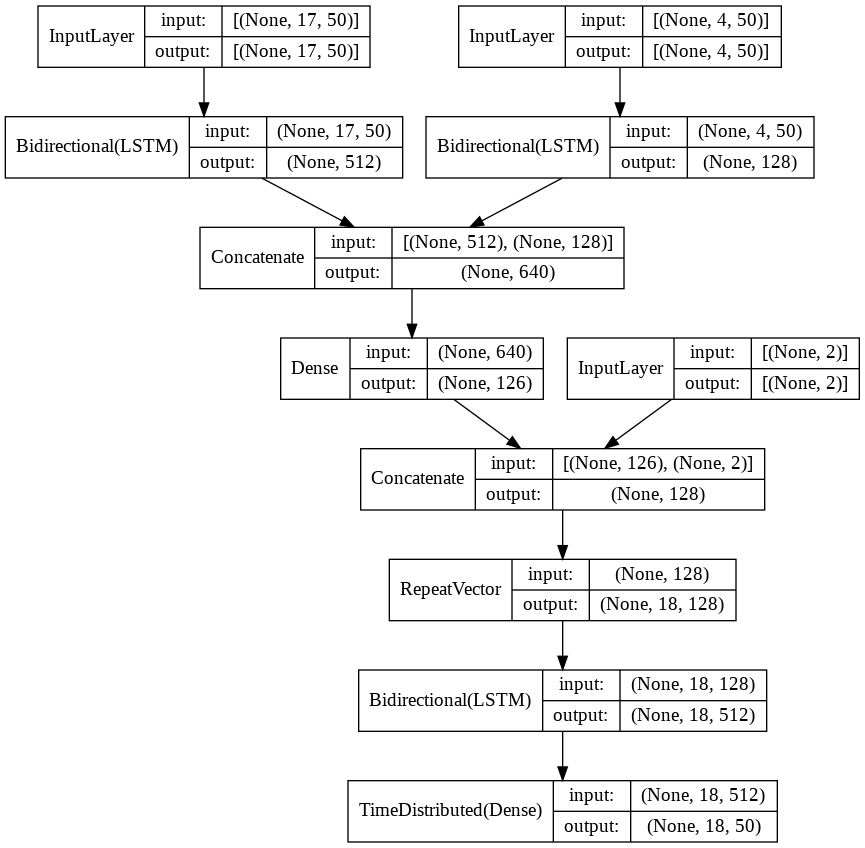

In [ ]:
print(model2.summary())
plot_model(model2, to_file=path+'/model 2/architecture.png', show_shapes=True, show_layer_names=False)

In [ ]:
model = load_model(checkpoint_filepath)
model.evaluate([X_test_singularPattern_OH, X_test_root_OH, X_test_genRat], y_test_plPattern_OH)

35/35 [==============================] - 2s 8ms/step - loss: 0.0032 - accuracy: 0.9736


[0.0032125026918947697, 0.9735569953918457]

In [ ]:
print(X_test_lemma[0].shape)
# model.predict([X_test_lemma[0], X_test_root[0], X_test_genRat[0]])
# print(X_test_lemma[0])
print(np.argmax(model2.predict([X_test_singularPattern_OH, X_test_root_OH, X_test_genRat])[0][0]))
print(np.argmax(y_test_plPattern_OH[0][0]))

(17,)
35/35 [==============================] - 2s 7ms/step
8
8


## **Model 4**
lemma - plural pattern

In [ ]:
input_lemma = Input(shape=(lemma_length, encode_size))
input_root = Input(shape=(root_length, encode_size))
input_genRat = Input(shape=(genRat_length, ))
input_numOfRoot = Input(shape=(numOfRoot_length, ))


lstm1 = Bidirectional(LSTM(128))(input_lemma)
lstm2 = Bidirectional(LSTM(128))(input_root)

c = Concatenate(axis=1)([lstm1, lstm2])

d = Dense(254, activation='relu')(c)

c = Concatenate(axis=1)([d, input_genRat])

r = RepeatVector(plPattern_length)(c)

lstm1 = Bidirectional(LSTM(128, return_sequences=True))(r)
# lstm2 = Bidirectional(LSTM(256, return_sequences=True))(lstm1)

output = TimeDistributed(Dense(encode_size, activation='softmax'))(lstm1)

model3 = Model(inputs=[input_lemma, input_root, input_genRat, input_numOfRoot], outputs=output)

checkpoint_filepath = path + '/model 3/best model.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

model3.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
  model3.fit([X_train_lemma_OH, X_train_root_OH, X_train_genRat, X_train_numOfRoot], y_train_plPattern_OH, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=([X_dev_lemma_OH, X_dev_root_OH, X_dev_genRat, X_dev_numOfRoot], y_dev_plPattern_OH))  # starts training

Epoch 1/100
43/43 [==============================] - 11s 80ms/step - loss: 1.8695 - accuracy: 0.5452 - val_loss: 1.3001 - val_accuracy: 0.6137
Epoch 2/100
43/43 [==============================] - 1s 20ms/step - loss: 1.2023 - accuracy: 0.6192 - val_loss: 1.1079 - val_accuracy: 0.6369
Epoch 3/100
43/43 [==============================] - 1s 20ms/step - loss: 1.0708 - accuracy: 0.6367 - val_loss: 0.9947 - val_accuracy: 0.6590
Epoch 4/100
43/43 [==============================] - 1s 21ms/step - loss: 0.9937 - accuracy: 0.6577 - val_loss: 0.9503 - val_accuracy: 0.6671
Epoch 5/100
43/43 [==============================] - 1s 20ms/step - loss: 0.9297 - accuracy: 0.6792 - val_loss: 0.8702 - val_accuracy: 0.7015
Epoch 6/100
43/43 [==============================] - 1s 20ms/step - loss: 0.8620 - accuracy: 0.7131 - val_loss: 0.8120 - val_accuracy: 0.7282
Epoch 7/100
43/43 [==============================] - 1s 20ms/step - loss: 0.8079 - accuracy: 0.7356 - val_loss: 0.7760 - val_accuracy: 0.7408
Epoch

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 16, 48)]     0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None, 4, 48)]      0           []                               
                                                                                                  
 bidirectional_25 (Bidirectiona  (None, 256)         181248      ['input_39[0][0]']               
 l)                                                                                               
                                                                                                  
 bidirectional_26 (Bidirectiona  (None, 256)         181248      ['input_40[0][0]']         

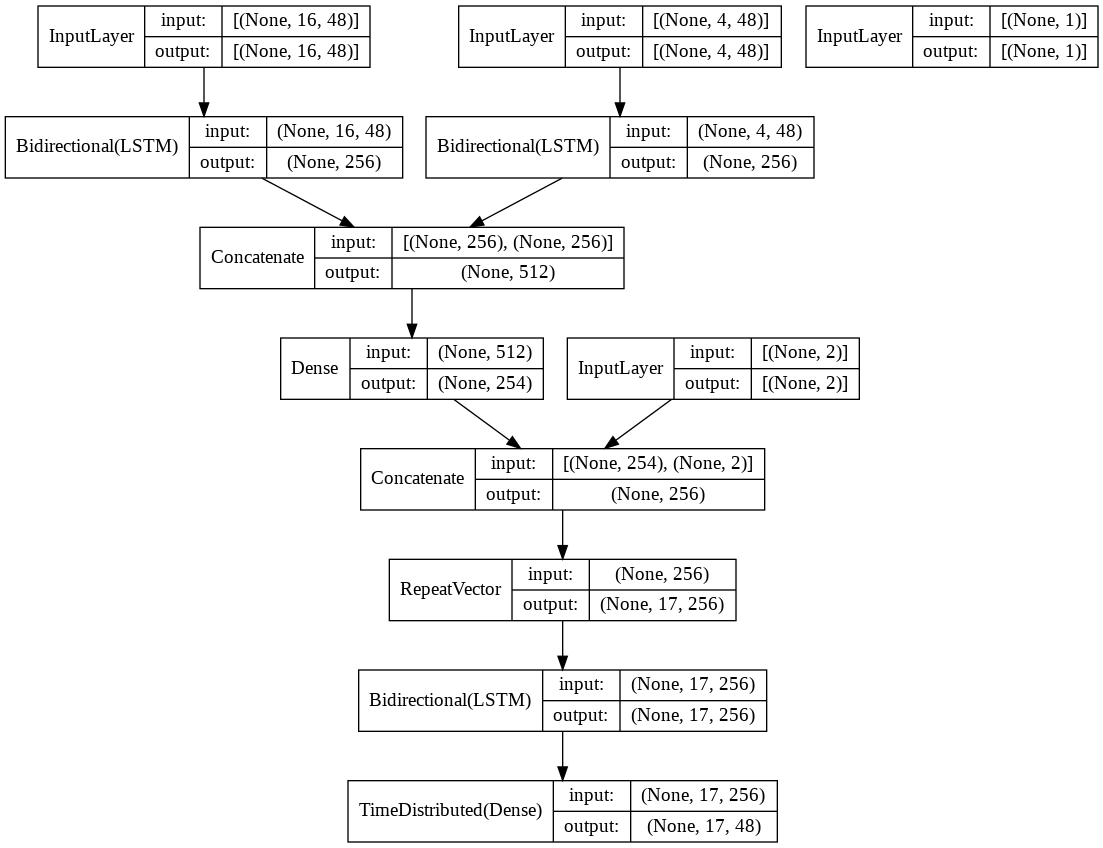

In [ ]:
print(model3.summary())
plot_model(model3, to_file=path+'/model 3/architecture.png', show_shapes=True, show_layer_names=False)

In [ ]:
model = load_model(checkpoint_filepath)
model.evaluate([X_test_lemma_OH, X_test_root_OH, X_test_genRat, X_test_numOfRoot], y_test_plPattern_OH)

34/34 [==============================] - 2s 7ms/step - loss: 0.0973 - accuracy: 0.9712


[0.09726995974779129, 0.9711896181106567]

In [ ]:
pred_plPattern = model.predict([X_test_lemma_OH, X_test_root_OH, X_test_genRat, X_test_numOfRoot])

print(pred_plPattern.shape)
print(y_test_plPattern_OH.shape)

34/34 [==============================] - 2s 6ms/step
(1076, 17, 48)
(1076, 17, 48)


In [ ]:
reportErrorAnalysis(testData[0],pred_plPattern,y_test_inflection_OH, path+"/model 3/test_errorAnalysis.csv")

In [ ]:
pred_plPattern = oneHot3D(pred_plPattern)

In [ ]:
checkAccuracy(pred_plPattern, y_test_plPattern_OH)

0.7955390334572491

In [ ]:
BSClassification_path = '/content/drive/MyDrive/AI Projects/Arabic Broken Plural/Results/Classification Models'
BSClassification_checkpoint_filepath = BSClassification_path + '/model 1/model 1.hdf5'